### Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rpy2 
%load_ext rpy2.ipython
%run pybase
%run heavysnow 

### Data 

In [2]:
f=np.array([-1,-1,-1,1,-1,-1,-1,1,1,1,-1,1,1,1])*1.0
n=len(f)
V=list(range(n))
W=np.zeros([n,n])
for i in range(n):
    for j in range(n):
        if abs(i-j)==1: W[i,j]=1
W[0,0]=0
W[n-1,n-1]=0

In [3]:
gs=GraphSignal(V,W,f)

In [4]:
gs.initdist=np.array([1/n]*n)

### HST

In [5]:
%run heavysnow 
hst=HeavySnowTransform(gs)
hst.snow(tau=80000,b=0.015,maxflow=2)

HST (tau= 80000, b=0.015)
80000/80000
HST completed and all history is recorded.


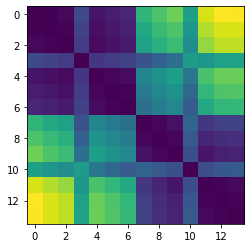

In [6]:
plt.imshow(hst.snowdistance)

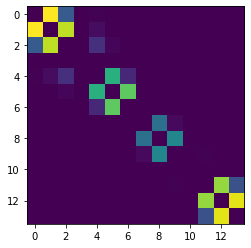

In [7]:
hst.snowweight=np.exp(-hst.snowdistance/(hst.tau*hst.b**1.5))-np.eye(n,n)
plt.imshow(hst.snowweight)

### 시각화를 위해서 R로 자료를 옮김

In [8]:
maxtau=hst.tau
W_Graph=hst.graphweight
W_Euclid=hst.euclidweight
W_HST=hst.snowweight
V=np.array(hst.V)
f=hst.f
n=hst.n
%R -i maxtau,W_Graph,W_Euclid,W_HST,V,f,n

### R을 활용한 시각화 (1): 원래자료 

In [9]:
%%R -w 2000 -h 800 -r 100
library(tidyverse)
library(latex2exp)
library(gridExtra)
source('rbase.R')
Vtext=str_c('node ',V+1)
fig0<-ggplot(data=tibble(V=V,f=f,Vtext=Vtext),aes(x=V,y=f,label=Vtext))+
geom_col(aes(fill=(f>0)),width=0.1)+geom_hline(aes(yintercept=0),col="gray60",lty=2)+
geom_text(fontface = 4,size=8)+
xlab("")+ylab("")+guides(fill=FALSE)+theme(plot.title=element_text(face="bold.italic"))+theme_bw()+
theme(strip.text.x = element_text(size = 20, color = "black", face = "bold.italic"))+
theme(strip.text.y = element_text(size = 15, color = "black", face = "bold.italic"))+
ylim(-1.2,1.2)+
theme(plot.title=element_text(face="bold.italic"))
#ggsave(plot=p0,"./fig/2021-0217_fig0.pdf",width=20,height=6)
fig0

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.3     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: Error in library(gridExtra) : there is no package called ‘gridExtra’




Error in library(gridExtra) : there is no package called ‘gridExtra’


RInterpreterError: Failed to parse and evaluate line 'library(tidyverse)\nlibrary(latex2exp)\nlibrary(gridExtra)\nsource(\'rbase.R\')\nVtext=str_c(\'node \',V+1)\nfig0<-ggplot(data=tibble(V=V,f=f,Vtext=Vtext),aes(x=V,y=f,label=Vtext))+\ngeom_col(aes(fill=(f>0)),width=0.1)+geom_hline(aes(yintercept=0),col="gray60",lty=2)+\ngeom_text(fontface = 4,size=8)+\nxlab("")+ylab("")+guides(fill=FALSE)+theme(plot.title=element_text(face="bold.italic"))+theme_bw()+\ntheme(strip.text.x = element_text(size = 20, color = "black", face = "bold.italic"))+\ntheme(strip.text.y = element_text(size = 15, color = "black", face = "bold.italic"))+\nylim(-1.2,1.2)+\ntheme(plot.title=element_text(face="bold.italic"))\n#ggsave(plot=p0,"./fig/2021-0217_fig0.pdf",width=20,height=6)\nfig0\n'.
R error message: 'Error in library(gridExtra) : there is no package called ‘gridExtra’'

### R을 활용한 시각화 (2): Weight matrix 와 Eigen plot 

`-` `ggplot`에서 `geom_tile`을 사용하기 위해서 매트릭스 형태인 `W_Graph`, `W_Euclid`, `W_HST`를 길게 펼친다. 결과를 각각 `W_Graph_long`, `W_Euclid_long`, `W_HST_long`에 저장한다. 

In [ ]:
%%R
grid<-expand.grid(x=1:n,y=1:n)
W_Graph_long<-as_tibble(cbind(grid,as.vector(W_Graph)));names(W_Graph_long)<-c("x","y","W")
W_Euclid_long<-as_tibble(cbind(grid,as.vector(W_Euclid)));names(W_Euclid_long)<-c("x","y","W")
W_HST_long<-as_tibble(cbind(grid,as.vector(W_HST)));names(W_HST_long)<-c("x","y","W")

`-` 그래프퓨리에 변환: $(\bf{f},\bf{W})$에 그래프 퓨리에 변환을 수행함.  

In [ ]:
%%R
source('heavysnow.R')
gfftrslt_Euclid<-gfft(f,W_Euclid)
gfftrslt_Graph<-gfft(f,W_Graph)
gfftrslt_HST<-gfft(f,W_HST)

`-` 그래프 퓨리에 변환의 결과 고유치, 고유벡터, $\bf{\bar{f}}$가 반환됨. 

In [ ]:
%%R
head(gfftrslt_HST)

`-` 시각화코드 

In [ ]:
%%R -w 1000 -h 800 -r 100
library(gridExtra)

fig1_1<-ggplot()+geom_tile(data=W_Euclid_long,aes(x=x,y=y,fill=W))+theme_bw()+xlab("")+ylab("")+
theme(strip.text.x = element_text(size = 20, color = "black", face = "bold.italic"))+
theme(strip.text.y = element_text(size = 20, color = "black", face = "bold.italic"))+
scale_fill_gradient2(low="red",high="blue",mid="purple",midpoint=0.25,breaks=c(0,0.5,0.99))+
labs(fill=TeX('$W$'))+
theme(legend.position="none")+theme(legend.key=element_blank())+
ggtitle("(a) Euclid")+theme(plot.title=element_text(face="bold.italic",size=rel(3)))

fig1_2<-ggplot()+geom_tile(data=W_Graph_long,aes(x=x,y=y,fill=W))+theme_bw()+xlab("")+ylab("")+
theme(strip.text.x = element_text(size = 20, color = "black", face = "bold.italic"))+
theme(strip.text.y = element_text(size = 20, color = "black", face = "bold.italic"))+
scale_fill_gradient2(low="red",high="blue",mid="purple",midpoint=0.5,breaks=c(0,0.5,0.99))+
labs(fill=TeX('$\\hat{W}$'))+
theme(legend.position="none")+theme(legend.key=element_blank())+
ggtitle("(b) Graph")+theme(plot.title=element_text(face="bold.italic",size=rel(3)))

fig1_3<-ggplot()+geom_tile(data=W_HST_long,aes(x=x,y=y,fill=W))+theme_bw()+xlab("")+ylab("")+
theme(strip.text.x = element_text(size = 20, color = "black", face = "bold.italic"))+
theme(strip.text.y = element_text(size = 20, color = "black", face = "bold.italic"))+
scale_fill_gradient2(low="red",high="blue",mid="purple",midpoint=0.5,breaks=c(0,0.5,0.99))+
labs(fill=TeX('$\\hat{W}(\\tau)$'))+
theme(legend.position="none")+theme(legend.key=element_blank())+
ggtitle("(c) HST")+theme(plot.title=element_text(face="bold.italic",size=rel(3)))

fig1_4<-eigenplot(gfftrslt_Euclid)+ylim(0,2)+theme_light()
fig1_5<-eigenplot(gfftrslt_Graph)+ylim(0,2)+theme_light()
fig1_6<-eigenplot(gfftrslt_HST)+ylim(0,2)+theme_light()
fig1=grid.arrange(fig1_1,fig1_2,fig1_3,fig1_4,fig1_5,fig1_6,ncol=3,nrow=2)
fig1
#ggsave(plot=grid.arrange(p1_a,p1_b,p1_c,ncol=3),"2021-07-22_fig1.png",width=20,height=4)

### R을 활용한 시각화 (3): Decomposition 

`-` 디콤포지션을 수행하고 결과를 저장: $(\bf{f},\bf{W})$에 decomposition을 수행하고 그 결과를 각각 `decomprslt_Euclid`, `decomprslt_Graph`, `decomprslt_HST`에 저장한다. 

In [ ]:
%%R 
decomprslt_Euclid<-decompose(f,W_Euclid,V=1:n) # 0, 35000, 60000, 80000
decomprslt_Graph<-decompose(f,W_Graph,V=1:n) # 0, 35000, 60000, 80000
decomprslt_HST<-decompose(f,W_HST,V=1:n) # 0, 35000, 60000, 80000

`-` 디콤포지션 결과는 아래와 같은 형태임 

In [ ]:
%%R
head(decomprslt_Euclid)

In [ ]:
%%R 
decomprslt_Euclid$method="Euclid"
decomprslt_Graph$method="Graph"
decomprslt_HST$method="HST"
decomprslt<-rbind(decomprslt_Euclid,decomprslt_Graph,decomprslt_HST)

`-` 디콤포지션결과를 시각화한다. `geom_col`과 `facet_grid`를 이용. 

In [ ]:
%%R -w 2000 -h 500 -r 100
fig2<-ggplot(data=decomprslt,aes(x=V,y=fhat))+
geom_col(aes(fill=fhat>0),width=0.7)+facet_grid(method~eigenvectorindex)+geom_hline(aes(yintercept=0),col="gray60",lty=2)+
xlab("")+ylab("")+guides(fill=FALSE)+theme(plot.title=element_text(face="bold.italic"))+theme_bw()+
theme(strip.text.x = element_text(size = 20, color = "black", face = "bold.italic"))+
theme(strip.text.y = element_text(size = 15, color = "black", face = "bold.italic"))+
ylim(-1.5,1.5)+
theme(plot.title=element_text(face="bold.italic"))
fig2
#ggsave(plot=fig2,"./fig/2021-0514_fig2.pdf",width=20,height=6)